# 1. 목표  

>  캘리포니아 인구 조사 데이터를 사용해 캘리포니아의 주택 가격 모델 만들기 

# 2. 데이터 가져오기 

## 데이터 다운로드 함수 생성 
- 재사용성을 높일 수 있음 

In [2]:
import pandas as pd 
import tarfile
import urllib.request
from pathlib import Path

In [3]:
def load_housing_data():
    ### 다운로드 받을 경로 선언
    trail_path = Path('datasets/housing.tgz')

    ### 다운로드 받을 경로에 디렉토리가 없다면 디렉토리 생성
    if not trail_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
    
    ### 데이터 경로 선언 
    url = "https://github.com/ageron/data/raw/main/housing.tgz"

    ### 다운로드 리퀘스트 
    urllib.request.urlretrieve(url, trail_path)

    ### 받아온 tgz 파일을 열기
    with tarfile.open(trail_path) as housing_traball:
        ### tgz 파일에서 housing.csv 파일을 추출
        housing_traball.extractall(path="datasets") 

    ### 받아온 csv를 리턴 
    return pd.read_csv( "datasets/housing/housing.csv")

- 함수를 이용해 데이터를 불러옴 

In [4]:
housing = load_housing_data()

C:\Users\skssk\AppData\Local\Temp\ipykernel_23648\3392672599.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_traball.extractall(path="datasets")


# 3. 데이터 확인

### head() 로 대략적인 확인 
  - 특성 : 10개로 확인 

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### info()로 type 과 null 확인 
- 총 데이터 : 20640
-  total_bedrooms  : 데이터가 적음 (20433)
-  ocean_proximity 를 제외하고 모두 숫자형
   -  ocean_proximity는 문자열로 추정됨

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### ocean_proximity 데이터 확인 
- 유일하게 문자열인 데이터 
- `values_count()` 를 통해 데이터 요약을 받음 
- 범주형 데이터로 보임 

In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

# 4. 시각화로 데이터 특성 확인

- 히스토그램을 이용해 데이터의 특성을 확인
  
  ## 특징 확인 
  ### `median_income`의 스케일 
    - 0~15로 구성됨 
    - 0달러 ~ 15달러 (X) -> 0만 달러 ~ 15만달러 
    - 상한 값의 경우 15로 결정 

### `housing_median_age`와 `median_house_value` 범위 
- 중간 주택 연도와 중간 주택 가격의 최솟값과 최대값이 한정되어 있음 
  - 한계값 밖 구역에 대한 레이블을 추가하거나 이 범위를 제외한 데이터 셋을 사용 

### 특성들의 스케일
  - 특성들간 스케일이 다름 -> 표준화 필요 

### 데이터의 분포 
  - Skewed Distribution(치우쳐진 분포)
  - 한쪽으로 꼬리가 김 

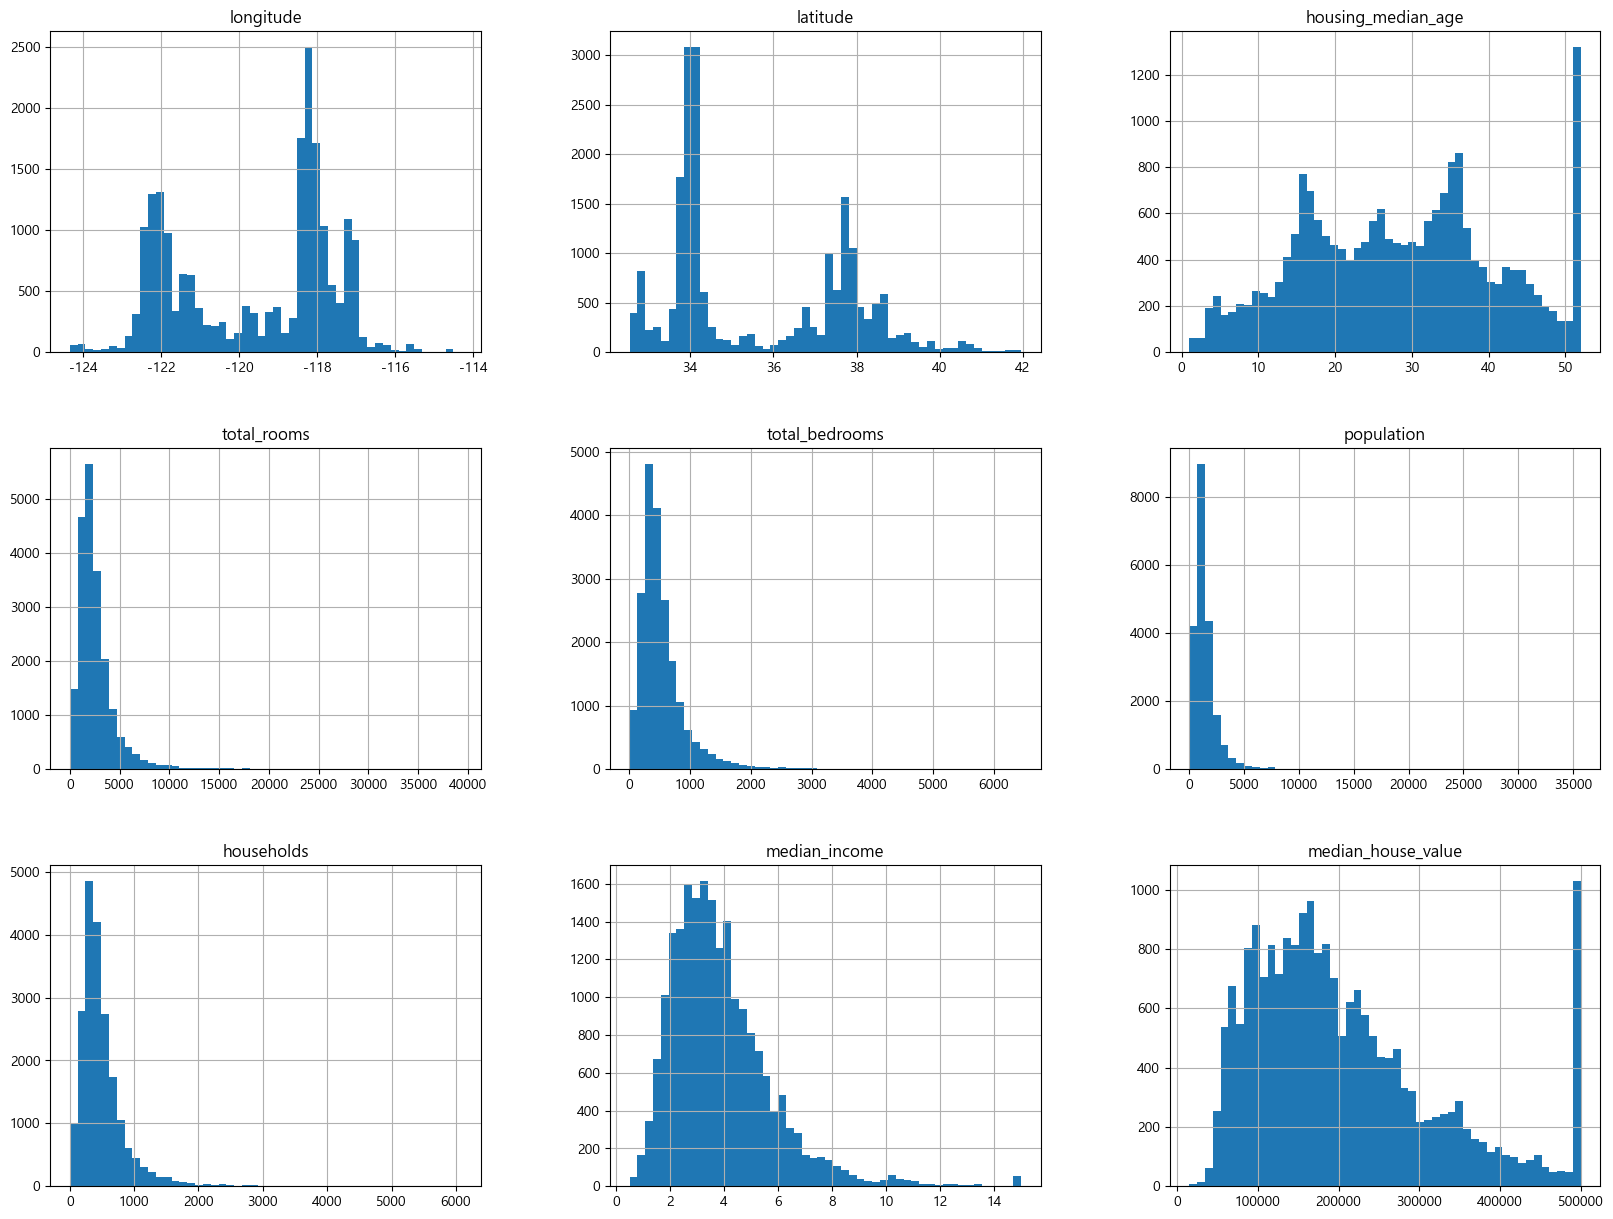

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

housing.hist(bins=50, figsize=(20,15))
plt.show()

# 5. 테스트 세트 만들기 

- 테스트 세트를 만드는 이유 : `데이터 스누핑 편향` 을 막기 위함 
  - 과대 적합을 막아야 함

- 테스트를 만드는 방법 : 데이터 세트에서 20% 때서 사용 
  - 사이킷런에서 제공하는 `sklearn.model_selection import train_test_split` 등 다양한 방식을 이용해 데이터 분리를 할 수 있다.

## Numpy 로 테스트 세트 나누기

- `np.random.permutation()` : 무작위로 섞는 함수
  - 단, 교재와 같은 출력값을 보기 위해 랜덤 시드 42로 설정 

### numpy 임포트 

In [9]:
import numpy as np

### 함수 생성 
  - 파라미터로 나눌 데이터 (`data`)와 테스트 세트 비율 (`ratio`) 를 받음

In [11]:
def shuffle_and_split_data(data,test_ratio):
    ### 랜덤 시드 설정 
    np.random.seed(42)

    ### 데이터를 랜덤으로 섞음
    shuffled_indices = np.random.permutation(len(data))

    ### 테스트 세트 크기 설정 > data 크기 * test_ratio
    test_set_size = int(len(data) * test_ratio)

    ### 훈련 세트 /  테스트 세트 생성
    
    ### 테스트 세트 :0번째 인텍스 부터 test_set_size 까지
    test_indices = shuffled_indices[:test_set_size]

    ### 훈련 세트 : test_set_size 부터 끝까지
    train_indices = shuffled_indices[test_set_size:]

    ### 훈련 세트와 테스트 세트를 리턴
    ### iloc : 인덱스 위치로 데이터 프레임의 행을 선택
    return data.iloc[train_indices], data.iloc[test_indices]

- 함수 테스트

In [12]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

print(f"훈련 세트 크기: {len(train_set)}")
print(f"테스트 세트 크기: {len(test_set)}")

훈련 세트 크기: 16512
테스트 세트 크기: 4128


### 한계 
- 업데이트 된 데이터 셋을 사용 시 문제 
  - 업데이트된 데이터 셋에서도 안정적으로 사용하려면 `식별자`를 사용하함 
 - random seed를 사용하면 데이터가 다르게 섞임 

## zlib을 사용한 방법 
- id의 해시값을 이용해서 테스트 세트를 나눔

- 패키지 임포트 

In [ ]:
from zlib import crc32

- 테스트 안에 있는 데이터인지 확인하는 함수 

In [14]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier))  < test_ratio * 2**32

- 해시 값을 이용해 데이터를 나눔 

In [15]:
def split_data_with_id_hash(data, test_ratio, id_column):
    ### 식별자 컬럼을 받음
    ids = data[id_column]
    
    ### 테스트 세트 안에 있는지 확인 
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

- `hosuing` 데이터 안에는 식별자가 없음 
  - 인덱스를 식별자로 사용함 

In [16]:
### 인덱스 생성 
housing_with_id = housing.reset_index() 

### 데이터 나누기 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

### 인덱스를 ID로 사용하는 것의 한계 
- 새로운 데이터는 끝에 추가되어야함 
- 행이 삭제되어선 안됨 

#### 대체 방법
- 고유한 식별자로 사용하기 안전한 특성을 사용함 
- 예시 : 위도 경도 

In [17]:
### 위도 경도를 이용하여 아이디 생성 
housing_with_id["id"] = housing_with_id["longitude"] * 1000 + housing_with_id["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

## 사이킷 런을 이용한 데이터 나누기 

- 사이킷 런에서는 테스트 세트를 나누는 다양한 방법을 제공 

### train_test_split
  - `random_state`를 이용해 시드를 설정 가능 
  - 행 개수가 동일한 데이터 셋을 넘겨 동일한 인덱스를  기반으로 나눌 수 있음 
    - 특성 데이터프레임과 타겟 데이터 프레임을 넘기면 동일하게 나눌 수 있음 

In [18]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## 계층적 샘플링
- `계층`이라는 동질 그룹을 나눈 후 각 그룹에서 샘플링을 진행하는 방법
- `pd.cut()` 함수를 사용해 카테고리를 나눌 수 있음 


### 예시 : 소득 수준 카테고리 나누기 
-  `median_income` : 소득 컬럼 
- `bins` : 소득 구간을 0, 1.5,3.0....`np.inf(무한대)` 로 구간을 나눔 
- `labels` : 각 구간에 대한 레이블을 붙임 

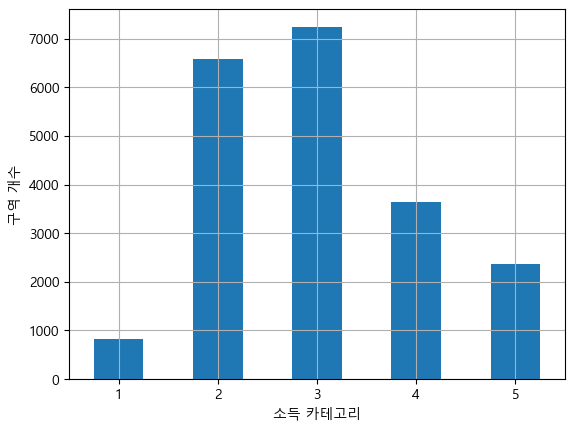

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                labels=[1, 2, 3, 4, 5])

### 시각화 진행 
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

### split() 매서드 
  -데이터가 아닌 인덱스를 반환하는 매서드
 - 분할을 여러 개 하는 것이 모델 성능에 좋음

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

### 분할기  - 10번 나눔 
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

### 10번 분할된 것을 담을 리스트 
strate_splits = [] 

### housing 데이터를 housing["income_cat"] 컬럼을 기준으로 계층적 샘플링 진행
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    ### 훈련 세트와 테스트 세트 생성
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

    ### 훈련 세트와 테스트 세트를 튜플로 묶어 리스트에 추가
    strate_splits.append((strat_train_set, strat_test_set))

    ### 첫번째 분할 
    print(f"훈련 세트 및 테스트 세트 : {strate_splits[0]}")

훈련 세트 및 테스트 세트 : (       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  me

#### stratify 함수 
  - 단일 분할이 필요한 경우 

In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

### 각 개층별 비율 확인 
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

- 사용하지 않는 특성 삭제 

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)  # income_cat 컬럼 삭제

# 6. 데이터 이해를 위한 탐색 

## 지리적 데이터 셋 시각화 
- 위도 경도가 있기 때문에 지리 데이터로 시각화 
  - `alpha`값을 이용해 투명도 조절 -> 밀집된 영역 확인에 좋음
- 단, 테스트 세트는 복사하여 진행 

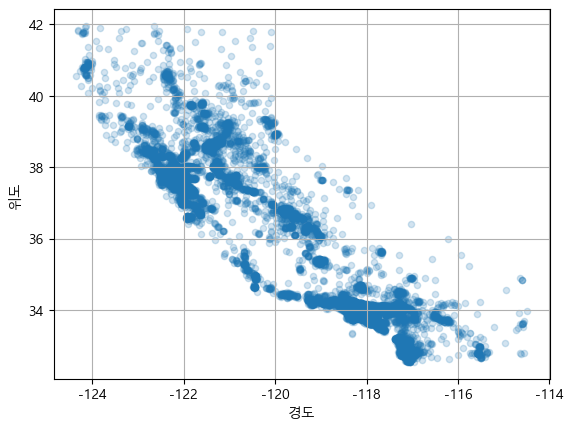

In [ ]:
### 복사
housing = strat_train_set.copy()

### 위도 경도 산점도 
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True,
             alpha=0.2)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

- 디테일 추가 
    -  원의 반지름 : 인구 수 
    -  색상 : 가격
-  결론 : 바다와 인접한 곳 및 인구 밀도와 가격의 관련성이 높음 

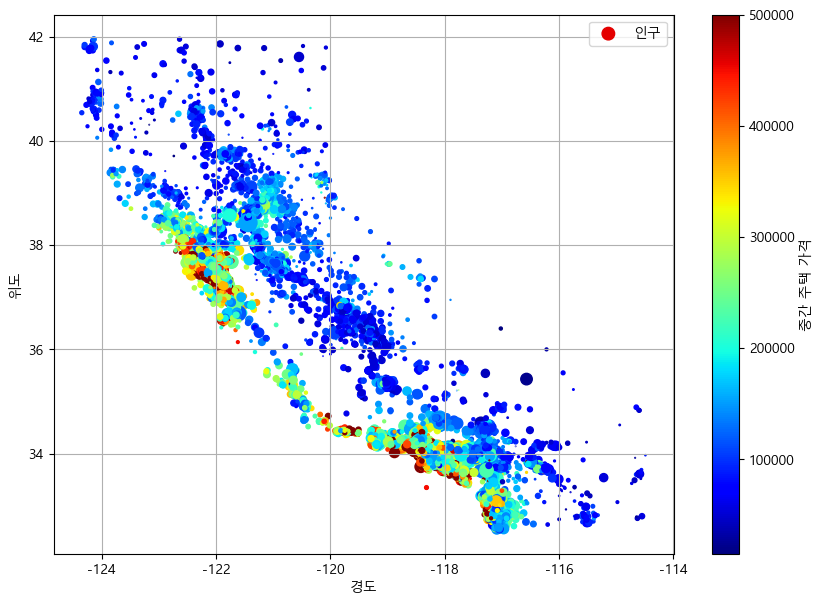

In [ ]:
### 위도 경도 산점도 
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True,
             s=housing["population"]/100,  label="인구", ### 인구 표시  = 원
             c=housing["median_house_value"], cmap="jet", colorbar=True, ### 중간 주택 가격 표시 =색상
             legend=True,
             figsize=(10, 7))

### 서브 플롯 선택 -> 컬러바
cax = plt.gcf().get_axes()[1]  
cax.set_ylabel("중간 주택 가격")

plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

## 상관관계 조사 
- 피어슨 $r$ (*피어슨 상관계수*) : 두 변수 간의 선형 관계를 측정하는 통계적 방법으로, -1에서 1 사이의 값을 가집니다.
  -  `표준 상관계수` 라고 함 
  -  `corr()`매서드로 계산 가능 
     -  `numberic_only =True`로 숫자만 적용

In [34]:
### 상관계수 계산
corr_matrix = housing.corr(numeric_only=True)

### 상관계수 행렬 출력
print("상관 계수 - median_house_value와의 상관계수 출력 ")
corr_matrix["median_house_value"].sort_values(ascending=False)

상관 계수 - median_house_value와의 상관계수 출력 


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

- 결과 해석  : median_income가 높은 상관관계가 있음 

### 판다스의 `scatter_matrix` 함수 사용
- 9x9 플롯이 그려짐 > 그래도 가능성이 좀 있는 것들 위주로 출력 
- 대각성 부분은 트거성의 히스토그램으로 나옴

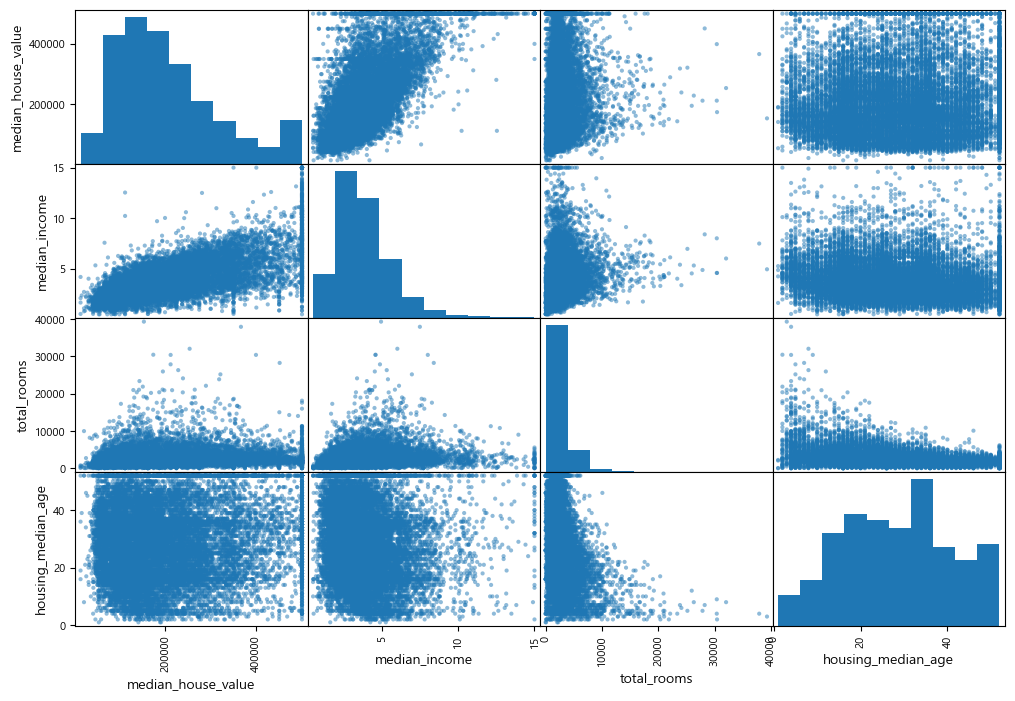

In [35]:
from pandas.plotting import scatter_matrix

### 관련있는 특성
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

- 분석결과 : 가장 유용한 특성 `중간 소득`

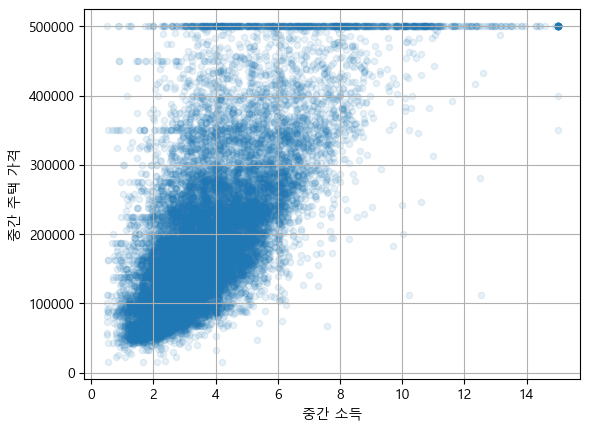

In [36]:
housing.plot(kind="scatter",
             x="median_income",
                y="median_house_value",
                alpha=0.1,
                grid=True)
plt.xlabel("중간 소득")
plt.ylabel("중간 주택 가격")
plt.show()

- 분석 결과 : 
  - 매우 강한 양의 상관 관계 
- 50만 달러대의의 직선 > 50만 달러가 상한선이었기 때문에
- 30~40만 달러대의 직선 > 이상치로 해석 가능 

-> 제거하여 데이터를 정제할 수 있음

## 특성 조합
- 알고리즘용  데이터를 준비하기전, 특성을 여러가지로 조합하여 유용한 조합을 찾아냄 
- 흥미로울만한 조합 
  - 집 당 방 갯수 
  - 침실 비율 
  - 집당 인구 

In [37]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_house"] = housing["population"] / housing["households"]

### 상관관계 행렬 출력 
corr_matrix = housing.corr(numeric_only=True)
print("상관 계수 - median_house_value와의 상관계수 출력 ")
corr_matrix["median_house_value"].sort_values(ascending=False)

상관 계수 - median_house_value와의 상관계수 출력 


median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_per_room      -0.256397
Name: median_house_value, dtype: float64

- `bedrooms_per_room` 이 다른 조합보다 상관 관계가 좀 더 높다는 것을 알 수 있음 

# 7. 머신러닝용 데이터 준비 

In [38]:
### 데이터 원복 
housing = strat_train_set.drop("median_house_value", axis=1)  
housing_labels = strat_train_set["median_house_value"].copy()

## 데이터 정제 
- 누락된 특성을 처리하는 함수 생성 

### 처리 방법 
- `dropna()`:해당 구역 제거 
- `drop()` : 전체 특성 제거 
- `fillna()` : 값 대체 (평균, 중간 값, 0 등)

In [39]:
### 해당 구역 제거 하는 방법 
housing.dropna(subset=["total_bedrooms"]) 

### 전체 특성 제거 하는 방법
housing.drop("total_bedrooms", axis=1)

### 값 대체 하는 방법 - 중간 값으로 대체 
### 데이터를 가장 많이 유지하기 때문에 선택 
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

13096    1115.0
14973     354.0
3785      217.0
14689     851.0
20507    1211.0
          ...  
14207     597.0
13105     592.0
19301     775.0
19121     873.0
19888     195.0
Name: total_bedrooms, Length: 16512, dtype: float64

### 사이킷런의 `SimpleImputer`
- 특성들의 `중간값`으로 누락된 값을 대체
- 훈련  세트 뿐만 아니라 테스트, 검증 세트, 새로운 데이터 셋에 대체 가능 

- `strategy` : 빈 값을 채우는 방법 
  - mean : 평균값
  - most_frequency : 최빈값
  - constant, fill_value : 상수 

- SimpleImputer를 제외하고 다른 것도 지원
  - KNNImputer : K최근접으로 대체 
  - IterativeImputer : 특성마다 회귀 모델 훈련 > 누락값 예측 

In [40]:
### 객체 생성 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

### 수치형 특성만 선택
housing_num = housing.select_dtypes(include=[np.number])

- `fit()` :  중간 값을계산 후 결과를 `statistics_` 속성에 저장 
- `imputer`를 적용하여 `total_bedrooms` 를 채움
- 사이킷런은 판다스 데이터프레임을 넣어도 `넘파이 배열`을 반환함 

In [43]:
### 중간값 계산 후 적용 
imputer.fit(housing_num)

### 실제 중간값 
print("특성 별 중간값 : ", housing_num.median().values)

### imputer로 계산된 중간값
print("imputer 계산 중간값 : ", imputer.statistics_)

### imputer를 적용하여 `total_bedrooms` 를 채움
X = imputer.transform(housing_num)

### 넘파이 배열 > 데이터프레임으로 변환 
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

특성 별 중간값 :  [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
imputer 계산 중간값 :  [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


### 텍스트 / 범주형 특성 처리 
- `OrdinalEncoder`를 이용하여 처리 

- 특성 값 확인 

In [49]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [51]:
from sklearn.preprocessing import OrdinalEncoder

### 처리를 위한 인코더 선언 
ordinal_encoder = OrdinalEncoder()

### 인코딩
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

### 인코딩 값 확인 
print("인코딩 값 : ", housing_cat_encoded[:8])

### 카테고리를 활용해 리스트 확인 
print("카테고리 : ", ordinal_encoder.categories_)

인코딩 값 :  [[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]]
카테고리 :  [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### 한계 
- bad, average , good과 같은 방식은 괜찮음 
- 하지만 머신러닝 알고리즘이 가까이 있는 두 값을 떨어져 있는 두 값보다 더 비슷하다고 생각함 
  - '<1H OCEAN', 'INLAND', 보단 '<1H OCEAN', 'NEAR OCEAN'이 더 비슷함 

#### 문제의 해결방법  
- 카테고리별 이진 특성으로 만듦 

-`원-핫 인코딩` :  0번 특성이 1이면 나머지는 0으로 만듦  
  - 나머지 의미 없는 특성은 `더미`특성 
  - 클래스 : `OneHotEncoder`
    - 출력 : 사이파이 희소행렬
      - 희소 행렬의 장점 : 메모리 절약 및 빠른 계산 속도 
    - `sparse=False`를 통해 넘파이 반환 가능 

In [86]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
hosing_cat_1hot = cat_encoder.fit_transform(housing_cat)

### 출력 : 사이파이 희소 행렬
print(type(hosing_cat_1hot))

### 넘파이 배열로 변환 
#cat_encoder = OneHotEncoder()
#print(hosing_cat_1hot.toarray())

### 카테고리 출력 
print("카테고리 : ", cat_encoder.categories_)

<class 'numpy.ndarray'>
카테고리 :  [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


- `get_dummies()` : 판다스에서도 범주형 특성을 원 핫 코딩으로 표현하는 카테고리마다 이진 특성을 만드는 함수 

In [87]:
### 테스트용 데이터 프레임 생성 
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


#### OneHotEncoder의 장점 
  - 훈련된 것을 기억함 
 - 위에서 테스트한 `df_test`를 적용하면 총 4개와 비교 

In [88]:
cat_encoder.transform(df_test)
print(f"cat_encoder.transform(df_test) : \n{cat_encoder.transform(df_test)}")

cat_encoder.transform(df_test) : 
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


- 알 수 없는 카테고리가 주어 졌을 때 예외를 발생 시킴
- `cat_encoder.handle_unknown = "ignore"`를 통해 예외 발생 가능

In [89]:
### 예외 제외 하는 방법 
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
print(pd.get_dummies(df_test_unknown))

cat_encoder.handle_unknown = "ignore"

cat_encoder.transform(df_test_unknown)
print(cat_encoder.transform(df_test_unknown))

   ocean_proximity_<2H OCEAN  ocean_proximity_ISLAND
0                       True                   False
1                      False                    True
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


- `feature_names_in` : 열 이름 저장 특성 
- `get_feature_names_out` : 열 이름을 반환하는 메서드

In [ ]:
print(f"feature_names_in_ : {cat_encoder.feature_names_in_}")

cat_encoder.get_feature_names_out()

df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)


feature_names_in_ : ['ocean_proximity']
   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0  


### 특성 스케일링
- 모든 특성의 범위를 동일하게 맞추는 작업 -> `min-max 스케일링(정규화)` 또는 `표준화`

#### min-max 스케일링
- 모든 특성을 0과 1 사이로 조정
  -  MinMaxScaler 사용
  - feature_range로 범위 지정 가능 

In [92]:
from sklearn.preprocessing import MinMaxScaler

### 범위를 -1 ~ 1 사이로 조정
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_tr = min_max_scaler.fit_transform(housing_num)

#### 표준화 
- 값이서 평균을 빼고 편차로 나눔 
  - 평균 0 , 표준편차 1
- 범위 설정 불가능
- StandardScaler를 사용하여 표준화 진행

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_tr = std_scaler.fit_transform(housing_num)

- 특성 분포의 꼬리가 두꺼울 때( 예시 : `멱법칙 분포`), `정규화`와 `표준화` 값을 작은 범위로 압축 -> 스케일링을 통해 정규분포 느낌으로 바꿈 
- `버킷타이징` : 분포를 거의 동일한 크기의 버킷으로 자름 


#### 멀티 모달 분포 
  - `모드`라고 부르는 정점이 두 개 이상 나타는 분포 
  - 버킷타이징을 사용하면 도움 가능 -> 버킷 ID 수치가 아닌 카테고리를 다룸 -> 인코딩이 필요함 

- `방어 기저 함수`
  - 특정 모드 사이 유사도를 나타내는 특성을 추가
 - 유사도를 측정하는 함수 -> `방어 기저 함수(RBF)`
    - 입력값과 고정 포인트 사이의 거리에만 의존하는 함수 

 - `가우스 RBF` : 입력값이 고정 포틴트에서 멀어질수록 출력값이 지수적으로 감소
  - 사이킷 런에서는 rbf_kernel 사용 
  - housing_median_age 와 35 사이 유사도를 잼 

In [104]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]],[[35]],gamma=0.1)

#### 출력값 변환 
- 꼬리 값이 너무 두껍다면 로그로 변환 가능 
- 다시 변환 하려면 지수를 취함 -> 역변환 수한 함수 `inverse_transform()`

In [96]:
from sklearn.linear_model import LinearRegression

### 표준화된 타겟 레이블 생성
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

###  모델 선언
model= LinearRegression()

### 모델 학습
model.fit(housing[["median_income"]],scaled_labels)

### 신규데이터 (가정)
some_new_data = housing[["median_income"]].iloc[:5]

### 예측
scaled_predictions = model.predict(some_new_data)

### 예측 값 역변환
predictions = target_scaler.inverse_transform(scaled_predictions)
print("예측 값 : ", predictions)

예측 값 :  [[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


##### 좀 더 간단한 방식 : TransformedTargetRegressor
- 변환 / 역변환을 자동으로 처리해주는 클래스

In [101]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=LinearRegression(),
                                   transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
print("예측 값 : ", predictions)

예측 값 :  [131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


#### 사용자 정의 변환기 
- 예시 : 로그값으로 변환하는 방법

In [102]:
from sklearn.preprocessing import FunctionTransformer

### 역변환 함수 = 지수 / 변환함수 = 로그함수 
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing["population"])

- 추가적인 인수를 하이퍼파라미터로 받을 수도 있음 
  - 가우스 rbf 유사도 계산 
    - 가우스 rbf는 역함수 없음 -> 항상 일정 거리만큼 떨어진 값을 항상 두기 때문

In [107]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

- 샌프란시스코 사이의 지리적 유사도 측정 

In [108]:
### 샌프란 시스코 좌표 
sf_coords = 37.7749, -122.41

### 유사도 측정을 위해 유클리드 거리 측정 
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

- 비율 계산 FunctionTransformer

In [110]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

##### 한계점 
- fit() 매서드에서 특정 파라미터를 학습하고 trainsform() 매서드에서이를 사용하기 위해 훈련 가능한 변환기가 필요한 경우 -> 사용자 정의 클래스를 작성해야함 
- 사이킷 런은 `덕타이핑`에 의존하기 때문에 이 클래스가 특정 클래스를 상속할 필요 없음
    - 필요한 매서드는 `fit()`, `transform()`,`fit_transform()` 

- `fit_transform()` 은 `TransfomerMixni`을 상속 -> 자동 생성됨 
    - fit과 transform을 연속으로 호출함 
   - `BestEstimator` 상속 시, 하이퍼파라미터 튜닝에 필요한 매서드 `get_params()`와 `set_params()`사용 가능 

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

In [113]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    
    ### args 혹은 kwargs를 사용하지않음
    def __init__(self, with_mean=True):
        self.with_mean =with_mean

    ### fit 매소드 수정 
    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        
        ### 모든 추정기는 fit()에서 이를 저장함
        self.n_features_in_ = X.shape[1]
        return self

    ### transform 매소드 수정
    ### X를 표준화하는 매소드
    def transform(self, X):
        #### 훈련으로 학습된 속성이 있는지 확인
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X -self.mean_
        return (X - self.mean_) / self.scale_

#### 주의 사항 
- `sklearn,utils.vaildation` 패키지에는 입력을 검증하기 위해 사용하는 함수가 있음 
- 사이킷런은 X와 y 두 개의 매개변수를 가진 매서드가 필요 
    - y를 사용하지 않아도 선언은 필요 `y=None`
- 모든 추정기의 `fit()`는 매서드 안에서 `n_features_in_` 속성을 설정 필요
  - transform() dhk predict() 매서드에 전달된 데이터 특성 개수가 동일한지 확인 필요 
- `fit()`은 self를 리턴해야 함
- 이 구현은 완벽하지 않음 

#### 사용자 변환기 안 다른 추정기 사용 
- `Kmeans`를 이욯하여 사용자 변환기 생성 
- transfroms() 매서드에서 rbf_kernel()f로  클러스터 중심과 얼마나 가까운지 측정 

In [114]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    ### fit() 매서드에서 KMeans를 사용하여 클러스터 중심을 찾기 
     # `n_init='auto'`로 지정하면 초기화 방법을 지정하는 `init='random'`일 때 10, `init='k-means++'`일 때 1이 됩니다.
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # 항상 self를 반환합니다!

### rbf_kernel()로 클러스터 중심과 얼마나 가까운지 찾기 
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]

- `n_clusters` : 클러스터 개수 하이퍼파라미터 지정 
- `cluster_centers_` 클러스터의 중심 속성 
- `Kmeans`의 fit 매서드는 sample_weight 인수를 받음
  -매개변수의 샘플의 상대적인 가중치를 지정 가능 

In [116]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=0.1, random_state=42)
similarties = cluster_simil.fit_transform(housing[["latitude","longitude"]],sample_weight=housing_labels)

In [117]:
print("RBF 유사도 출력 : ", similarties[:3].round(2))

RBF 유사도 출력 :  [[0.78 0.05 0.95 0.01 0.39 1.   0.19 0.54 0.02 0.82]
 [0.05 1.   0.1  0.72 0.46 0.05 0.8  0.   0.96 0.13]
 [0.92 0.04 0.89 0.   0.42 0.96 0.16 0.63 0.02 0.88]]


- 시각화

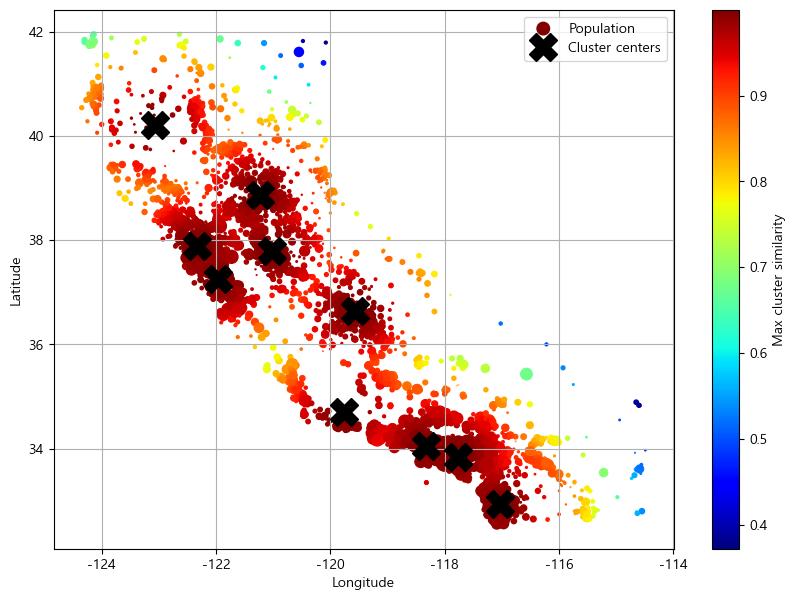

In [120]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarties.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## 변환 파이프 라인 
- `Pipeline` : 변환을 순서대로 처리 할 수 있는 클래스 
  - 리스트로 `(이름,추청기)` 튜플을 만들어야함 
  - 마지막 추정기를 제외하고 모두 `변환기`여야 함 (=fit_transform() 을 가짐)
  
- make_pipeline() : 변환기를 받고 클래스 이름을 밑줄 문자 없이 소문자로 바꾸어서 객체를 만듬
  - fit()을 사용하면  모든 변환기의 `fit_transform()` 매서드를 순서대로 호출 -> 마지막에 fit() 호출 
  - 매서드는 마지막 추정기를 기준으로 제공
    - 예시 : `StandardScaler` 추정기 -> transform()
      - 예측기를 사용할 경우, predict()

- 예시 : 수치 특성에서 누락된 값을 대체하고 스케일을 조정하는 파이프라인

In [121]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
     # 중간값으로 결측치 대체
    ("imputer", SimpleImputer(strategy="median")),
    # 표준화 
    ("standard", StandardScaler())  
])

- 예시 : `make_pipeline()`을 사용하여 파이프라인 생성

In [122]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler())

- `fit_transform()`으로  처리 

In [124]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)


array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

- 데이터 프레임 재구성 

In [125]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [126]:
df_housing_num_prepared.head(2) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


### 파이프라인의 인덱싱 
- 인덱싱 지원 
- `pipeline[1]` : 두번째 추정기 선택
- `pipeline[:-1]` : 마지막 추정기 제외 모두
- num_pipeline["simpleimputer"] : simpleimputer 반환

- ColumnTransformer를 통하여 파이프라인을 나누어 처리 할 수 있음 
  - `make_column_transformer()` 함수로 이름 자동 지정 가능

- 예시 : ColumnTarnsformer로  cat_pipeline 범주형 특성 적용 

In [127]:
from sklearn.compose import ColumnTransformer

### 수치형 특성과 범주형 특성 분리
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

### 파이프라인 생성 : 결측치 (최빈값) , 원-핫 인코딩
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

### 전처리는 `ColumnTransformer`를 사용하여 여러 파이프라인을 결합
### 수치형 파이프라인과 범주형 파이프라인을 결합
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

- 예시 : `make_column_transformer()` : 이름 자동 지정

In [128]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

- 데이터 셋 적용 완료 

In [129]:
housing_prepared = preprocessing.fit_transform(housing)

## 머신러닝용 데이터 정리하기 
- 누락  값 처리 : 수치형특성은 중간 값 , 범주형의 경우 최빈값
- 범주형 특성은 원핫코딩 
-비율특성을 추가 
- 클러스터 유사도 특성 추가 
- 균등분포나 가우스 분포에 가까운 특성으로 만들기 위해 로그값을 취함 
- 모든 수치형 특성은 표준화

In [130]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # get_feature_names_out에 사용

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # 남은 특성: housing_median_age

In [131]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

- 출력 

In [132]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__클러스터 0 유사도', 'geo__클러스터 1 유사도',
       'geo__클러스터 2 유사도', 'geo__클러스터 3 유사도', 'geo__클러스터 4 유사도',
       'geo__클러스터 5 유사도', 'geo__클러스터 6 유사도', 'geo__클러스터 7 유사도',
       'geo__클러스터 8 유사도', 'geo__클러스터 9 유사도',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

# 8.모델 선택과 훈련 

## 훈련 세트에서 훈련하고 평가 

- 예시 : 선형 회귀 모델
  - 예측값이 많이 맞지 않음 

In [134]:
from sklearn.linear_model import LinearRegression

### 모델 생성 
line_reg = make_pipeline(preprocessing, LinearRegression())

### 훈련
line_reg.fit(housing, housing_labels)

### 예측 실행 
housing_predictions = line_reg.predict(housing)
print("예측 값 : ", housing_predictions[:5].round(2))

housing_labels.iloc[:5].values

예측 값 :  [242761.81 375862.79 127480.98  99355.3  324610.74]


array([458300., 483800., 101700.,  96100., 361800.])

### 성능 테스트 by RMSE
- `mean_squared_erro`에서 squared`는 삭제됨
- 넘파이를 이용해 제곱근을 씌움 

In [146]:
from sklearn.metrics import mean_squared_error
lin_mse =mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(f"선형 회귀 모델 RMSE : {lin_rmse:.2f}")

선형 회귀 모델 RMSE : 68647.96


- 예측 오차가 68,647 달러 -> 좋은 점수가 아님 
- 좋은 예측을 만들만큼 충분한 정보를 제공하지 못함 ->`과소적합`

## 과소 적합 해소 

- 과소 적합 해소 방법 : 과소 적합을 해결하는 모델을 선택하거나 더 좋은 특성을 주입 혹은 규제를 감소 

### 모델 변경 
- `DecisionTreeRegressor`를 사용하여 모델 변경

In [149]:
from sklearn.tree import DecisionTreeRegressor

### 학습 진행
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

### 예측 실행 
housing_predictions = tree_reg.predict(housing)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"결정 트리 모델 RMSE : {tree_rmse:.2f}")

결정 트리 모델 RMSE : 0.00


- RMSE가 0 -> 과대적합의 문제

## 교차 검증을 통한 평가 
- `K폴드교차검증`을 통해 모델을 평가할 수 있음

In [153]:
from sklearn.model_selection import cross_val_score

### K폴드 교차 검증 
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66366.983603
std       1976.844743
min      63557.655007
25%      65004.623899
50%      65886.897085
75%      68129.026040
max      69530.301101
dtype: float64

In [152]:
### 선형 모델의 점수를 계산
lin_rmses = -cross_val_score(line_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     69847.923224
std       4078.407329
min      65659.761079
25%      68088.799156
50%      68697.591463
75%      69800.966364
max      80685.254832
dtype: float64

In [ ]:
- 결정 트리도 좋은 모델이 아닌 것으로 보임 
  - 결정트리 RMSE : 66,868
  - 선형 회귀 RMSE : 69,858

### RandomForestRegressor 모델 선정 
- 일반적으로 앙상블 모델이 좋은 성능을 보임

In [155]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

In [157]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)

In [158]:
pd.Series(forest_rmses).describe() 

count       10.000000
mean     46938.209246
std       1018.397196
min      45522.649195
25%      46291.334639
50%      47021.703303
75%      47321.521991
max      49140.832210
dtype: float64

- RMSE : 17,474 
 - 과대 적합이 되어 있음 
 - 해결 방법 : 모델 단순화 및 제한 혹은 훈련데이터 추가 
 - 미세 튜닝을 통해 조절

# 9. 모델 미세 튜닝 

## 그리드 서치 
-  탐색하고자 하는 하이퍼파라미터와 시도해볼 값을 설정 
  - "preprocessing__geo__n_clusters" > "preprocessing" 추정기 찾음 / "geo" 변환기 차즘  

In [164]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002049BC18A70>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

`param_grid`에는 2가지 딕셔너리가 있음 
  -1번째 :  n_clusters와 max_features 값을 모두 평가
- 2번째 : 두번째 딕셔너리에 있는 값 모두 평가 

In [167]:
print(grid_search.best_params_)

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}


- 평균 점수 출력 

In [166]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# 추가 코드 – 데이터프레임을 깔끔하게 출력하기 위한 코드입니다
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43007,43683,44158,43616
13,15,8,43697,44011,44819,44176
7,10,6,43710,44133,45227,44356
9,10,6,43710,44133,45227,44356
6,10,4,43798,44233,45100,44377


## 랜덤 서치 
- 탐색 공간이 커질 때 그리드 서치 보다 선호 되는 경향이 있음 
- `HalvingRandomSearchCV`와 `HalvingGridSearchCV`처럼 하이퍼파라미터 탐색 클래스 제공 

In [168]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002049FD32480>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002049FD308F0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

## 앙상블
- 최상의 모델을 연결 -> 결정 트리의 앙상블(랜덤포레스트)가 결정 트리 하나보다 더 좋은 성능이 좋은 것 처럼 모델 그룹이 단일보다 더 성능이 좋음 

## 최상의 모델과 오차 분석 
- 최상의 모델을 분석하면 문제에 대한 인사이트 활용 가능 

- 예시 : RandomForestRegressor

In [169]:
final_model = rnd_search.best_estimator_  # 전처리 포함됨
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.18883049114642353), 'log__median_income'),
 (np.float64(0.07550690165952419), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06427087748676082), 'bedrooms__ratio'),
 (np.float64(0.0521695509969851), 'rooms_per_house__ratio'),
 (np.float64(0.04664258696240615), 'people_per_house__ratio'),
 (np.float64(0.04244311259449021), 'geo__클러스터 3 유사도'),
 (np.float64(0.02329106317954673), 'geo__클러스터 17 유사도'),
 (np.float64(0.022649484211911694), 'geo__클러스터 18 유사도'),
 (np.float64(0.02197243576680579), 'geo__클러스터 22 유사도'),
 (np.float64(0.01881537204558837), 'geo__클러스터 40 유사도'),
 (np.float64(0.017669986767360032), 'geo__클러스터 10 유사도'),
 (np.float64(0.01754694953848625), 'geo__클러스터 35 유사도'),
 (np.float64(0.017274903717750808), 'geo__클러스터 41 유사도'),
 (np.float64(0.0160556631074201), 'geo__클러스터 6 유사도'),
 (np.float64(0.015811758952117744), 'geo__클러스터 2 유사도'),
 (np.float64(0.01477755940463033), 'geo__클러스터 32 유사도'),
 (np.float64(0.013845596351349358), 'geo__클러스터 43 유사도'),
 (np.float64(0.01373803

## 테스트 세트로 평가 

In [171]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

41556.053474456494


- 신뢰 구간을 이용해서 RMSE의 95%  구함 

In [172]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39415.11928419, 43591.96637635])

- 테스트 RMSE가 검증 RMSE보다 낮기 때문에 성능이 낮아지진 않음 -> 하지만 이렇다고 튜닝하면 안됨 

# 론칭 / 모니터링 / 시스템 유지보수

- `joblib`를 사용하여 모델을 저장하

In [ ]:
import joblib
joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']

- 모델 로드하는 방법

In [ ]:
import joblib

# 추가 코드 – 책에는 간결함을 위해 제외함 
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # 새로운 구역이라 가정
predictions = final_model_reloaded.predict(new_data)